# Шаг 1

### Our Dataset: Disasters on social media
Для иллюстрации описываемых подходов мы будем использовать датасет «Катастрофы в социальных медиа».

Авторы рассмотрели свыше 10 000 твитов, которые были отобраны при помощи различных поисковых запросов вроде «в огне», «карантин» и «столпотворение». Затем они пометили, имеет ли твит отношение к событию-катастрофе (в отличие от шуток с использованием этих слов, обзоров на фильмы или чего-либо, не имеющего отношение к катастрофам).

Поставим себе задачу определить, какие из твитов имеют отношение к событию-катастрофе в противоположность тем твитам, которые относятся к нерелевантным темам (например, фильмам). Зачем нам это делать? Потенциальным применением могло бы быть эксклюзивное уведомление должностных лиц о чрезвычайных ситуациях, требующих неотложного внимания — при этом были бы проигнорированы обзоры последнего фильма Адама Сэндлера. Особая сложность данной задачи заключается в том, что оба этих класса содержат одни и те же критерии поиска, поэтому нам придется использовать более тонкие отличия, чтобы разделить их.

Далее мы будем ссылаться на твиты о катастрофах как «катастрофа», а на твиты обо всём остальном как «нерелевантные».

### Метки (Labels)

Наши данные имеют метки, так что мы знаем, к каким категориям принадлежат твиты. Как подчеркивает Ричард Сочер, обычно быстрее, проще и дешевле найти и разметить достаточно данных, на которых будет обучаться модель — вместо того, чтобы пытаться оптимизировать сложный метод обучения без учителя.

**Rather than spending a month figuring out an unsupervised machine learning problem, just label some data for a week and train a classifier. — Richard (@RichardSocher) March 10, 2017**

Вместо того, чтобы тратить месяц на формулирование задачи машинного обучения без учителя, просто потратьте неделю на то, чтобы разметить данные, и обучите классификатор.


In [ ]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
questions = pd.read_csv('/content/drive/MyDrive/Analysis/lab9/Tweets.csv', encoding='utf-8')

### Шаг 2.  Sanitizing input  Очистите ваши данные

Правило номер один: «Ваша модель сможет стать лишь настолько хороша,
насколько хороши ваши данные»

Одним из ключевых навыков профессионального Data Scientist является знание о том, что должно быть следующим шагом — работа над моделью или над данными. Как показывает практика, сначала лучше взглянуть на сами данные, а только потом произвести их очистку.
Чистый датасет позволит модели выучить значимые признаки и не переобучиться на нерелевантном шуме.

Далее следует чеклист, который используется при очистке наших данных (подробности можно посмотреть в коде).

1. Удалить все нерелевантные символы (например, любые символы, не относящиеся к цифро-буквенным).
1. Токенизировать текст, разделив его на индивидуальные слова.
1. Удалить нерелевантные слова — например, упоминания в Twitter или URL-ы.
1. Перевести все символы в нижний регистр для того, чтобы слова «привет», «Привет» и «ПРИВЕТ» считались одним и тем же словом.
1. Рассмотрите возможность совмещения слов, написанных с ошибками, или имеющих альтернативное написание (например, «круто»/«круть»/ «круууто»)
1. Рассмотрите возможность проведения лемматизации, т. е. сведения различных форм одного слова к словарной форме (например, «машина» вместо «машиной», «на машине», «машинах» и пр.)

После того, как мы пройдемся по этим шагам и выполним проверку на дополнительные ошибки, мы можем начинать использовать чистые, помеченные данные для обучения моделей.


### Проверка данных

Это выглядит нормально, но на самом деле нам не нужны URL-адреса, и мы хотели бы, чтобы все наши слова были строчными (Hello и HELLO очень похожи для нашей задачи).

In [ ]:
questions.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [ ]:
questions.tail()

textID                                               text  \
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral

In [ ]:
questions.describe()

textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27481  
unique         3  
top      neutral  
freq       11118

Давайте воспользуемся регулярными выражениями, чтобы очистить данные и сохранить их на диск для будущего использования.

In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, "text")
questions = standardize_text(questions, "selected_text")

questions.to_csv("/content/drive/MyDrive/Analysis/lab9/clean_data.csv")
questions.head()

textID                                               text  \
0  cb774db0d1                i`d have responded, if i were going   
1  549e992a42      sooo sad i will miss you here in san diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  i`d have responded, if i were going   neutral  
1                             sooo sad  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        sons of ****,  negative

In [ ]:
clean_questions = pd.read_csv("/content/drive/MyDrive/Analysis/lab9/clean_data.csv")
clean_questions.tail()

Unnamed: 0      textID  \
27476       27476  4eac33d1c0   
27477       27477  4f4c4fc327   
27478       27478  f67aae2310   
27479       27479  ed167662a5   
27480       27480  6f7127d9d7   

                                                    text  \
27476   wish we could come see u on denver  husband l...   
27477   i`ve wondered about rake to.  the client has ...   
27478   yay good for both of you. enjoy the break - y...   
27479                         but it was worth it  ****.   
27480     all this flirting going on - the atg smiles...   

                                           selected_text sentiment  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          yay good for both of you.  positive  
27479                         but it was worth it  ****.  positive  
27480  all this flirting going on - the atg smiles. y...   neutral

### Анализ данных

Посмотрим на баланс данных

In [ ]:
clean_questions.groupby("sentiment").count()

Unnamed: 0  textID   text  selected_text
sentiment                                          
negative         7781    7781   7781           7781
neutral         11118   11118  11117          11117
positive         8582    8582   8582           8582

In [ ]:
clean_questions["text"]

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     i`ve wondered about rake to.  the client has ...
27478     yay good for both of you. enjoy the break - y...
27479                           but it was worth it  ****.
27480       all this flirting going on - the atg smiles...
Name: text, Length: 27481, dtype: object

In [ ]:
clean_questions = clean_questions.drop(314)

In [ ]:
# Задаем порядок категорий вручную
category_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
clean_questions['sentiment'] = clean_questions['sentiment'].map(category_mapping)

# Выводим DataFrame с закодированными значениями
print(clean_questions)

# Выводим отображение категорий в числа
print("\nMapping of categories to numbers:")
for category, number in category_mapping.items():
    print(f"{category}: {number}")

       Unnamed: 0      textID  \
0               0  cb774db0d1   
1               1  549e992a42   
2               2  088c60f138   
3               3  9642c003ef   
4               4  358bd9e861   
...           ...         ...   
27476       27476  4eac33d1c0   
27477       27477  4f4c4fc327   
27478       27478  f67aae2310   
27479       27479  ed167662a5   
27480       27480  6f7127d9d7   

                                                    text  \
0                    i`d have responded, if i were going   
1          sooo sad i will miss you here in san diego!!!   
2                              my boss is bullying me...   
3                         what interview! leave me alone   
4       sons of ****, why couldn`t they put them on t...   
...                                                  ...   
27476   wish we could come see u on denver  husband l...   
27477   i`ve wondered about rake to.  the client has ...   
27478   yay good for both of you. enjoy the break - y...   
274

In [ ]:
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text  sentiment  
0  i`d have responded, if i were going          2  
1                             sooo sad          0  
2                          bullying me          0  
3                       leave me alone          0  
4                        sons of ****,          0

Данные выглядят вполне сбалансированными

Нарисуем карту слов.

 i`d have responded, if i were going  sooo sad i will miss you here in san diego!!! my boss is bullying me...  what interview! leave me alone  sons of ****, why couldn`t they put them on the releases we already bought ://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth 2am feedings for the baby are fun when he is all smiles and coos soooo high  both of you  journey!? wow... u just became cooler.  hehe... (is that possible!?)  as much as i love to be hopeful, i reckon the chances are minimal =p i`m never gonna get my cake and stuff i really really like the song love story by taylor swift my sharpie is running dangerously low on ink i want to go to music tonight but i lost my voice. test test from the lg env2 uh oh, i am sunburned  s`ok, trying to plot alternatives as we speak *sigh* i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... ://tinyurl.com/mnf4kw is back home now      gonna miss eve

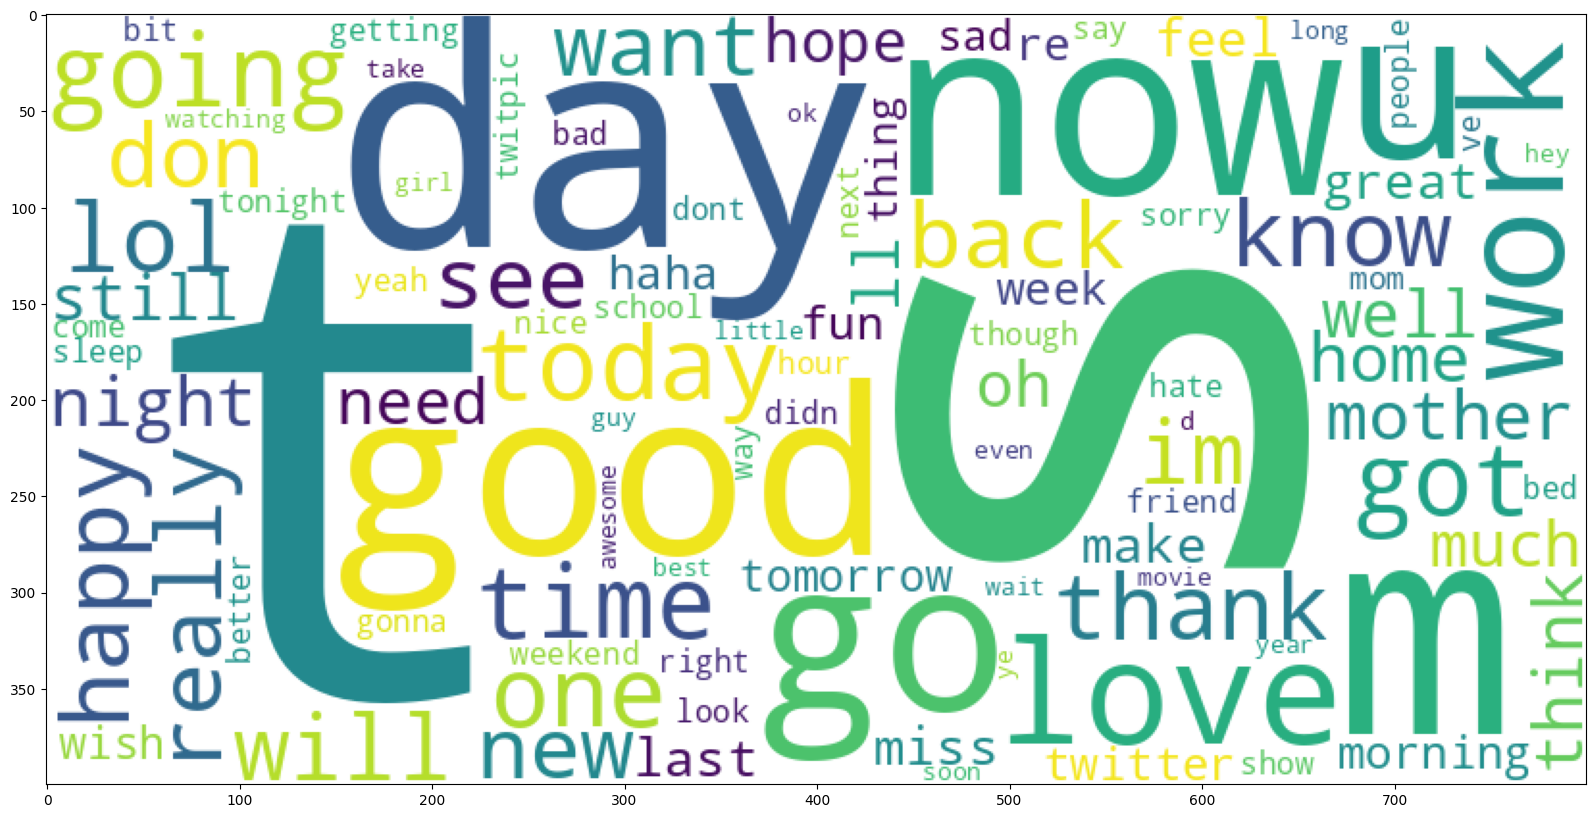

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

a = " ".join(clean_questions["text"])
print(a)

en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.imshow(en_cloud);

# Шаг 3.

### Наши данные чисты, теперь их нужно подготовить

Теперь, когда наши входные данные стали более разумными, давайте преобразуем их так, чтобы наша модель могла их понять. Из этого следует:
- Токенизация предложений в список отдельных слов
- Создание тестового сплита трейна
- Еще немного проверяем наши данные, чтобы подтвердить результаты.

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text  sentiment  \
0  i`d have responded, if i were going          2   
1                             sooo sad          0   
2                          bullying me          0   
3                       leave me alone          0   
4                        sons of ****,          0   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

In [ ]:
### Анализируем датасет дальше

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

367556 words total, with a vocabulary size of 26477
Max sentence length is 39


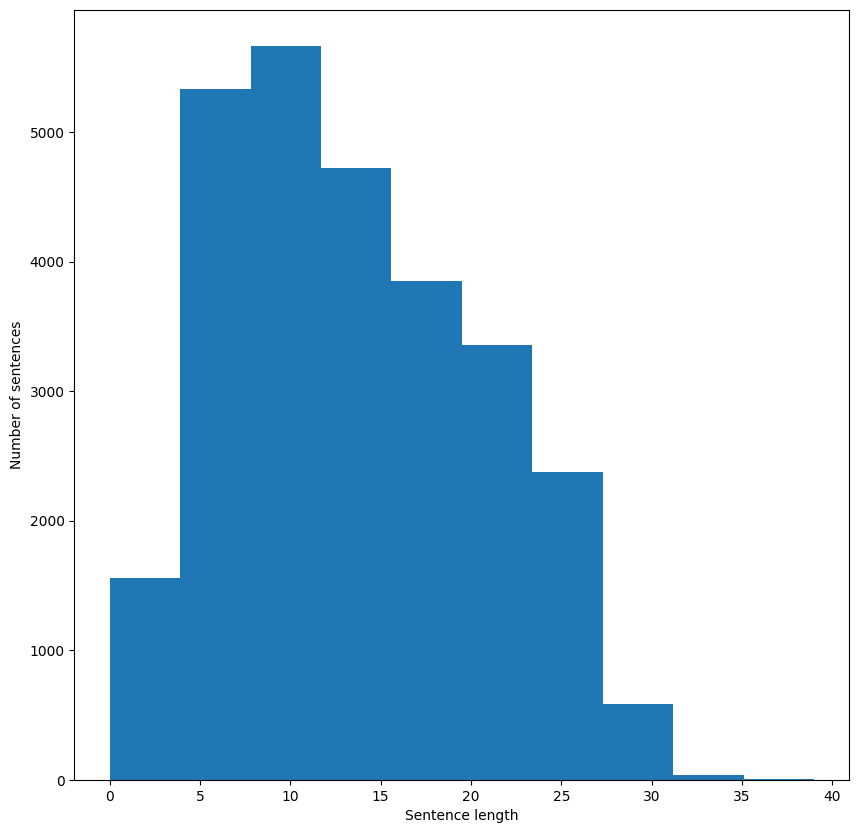

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

## К машинному обучению
Теперь, когда наши данные очищены и подготовлены, давайте займемся машинным обучением.

## Enter embeddings
 Машинное обучение для изображений может использовать необработанные пиксели в качестве входных данных. Алгоритмы обнаружения мошенничества могут использовать характеристики клиента/транзакций. Что может использовать НЛП?

Естественным способом представления текста для компьютеров является кодирование каждого символа по отдельности, что кажется совершенно неадекватным для представления и понимания языка. Наша цель — сначала создать полезное вложение для каждого предложения (или твита) в нашем наборе данных, а затем использовать эти вложения для точного прогнозирования соответствующей категории.

Самый простой подход, с которого мы можем начать, — это использовать модель мешка слов и применить к ней логистическую регрессию.
**Мешок слов** - мы можем построить словарь всех уникальных слов в нашем датасете, и ассоциировать уникальный индекс каждому слову в словаре. Каждое предложение тогда можно будет отобразить списком, длина которого равна числу уникальных слов в нашем словаре, а в каждом индексе в этом списке будет хранится, сколько раз данное слово встречается в предложении.
То есть мешок слов просто связывает индекс с каждым словом в нашем словаре и встраивает каждое предложение в виде списка нулей, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

## Bag of Words Counts

In [ ]:
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text  sentiment  \
0  i`d have responded, if i were going          2   
1                             sooo sad          0   
2                          bullying me          0   
3                       leave me alone          0   
4                        sons of ****,          0   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer



list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Визуализируем векторные представления

В словаре «Катастрофы в социальных медиа» содержится около 20 000 слов. Это означает, что каждое предложение будет отражено вектором длиной 20 000. Этот вектор будет содержать преимущественно нули, поскольку каждое предложение содержит лишь малое подмножество из нашего словаря.

Для того, чтобы выяснить, захватывают ли наши векторные представления (embeddings), релевантную нашей задаче информацию (например, имеют ли твиты отношение к катастрофам или нет), стоит попробовать визуализировать их и посмотреть, насколько хорошо разделены эти классы. Поскольку словари обычно являются очень большими и визуализация данных на 20 000 измерений невозможна, подходы вроде метода главных компонент (PCA) помогают спроецировать данные на два измерения.

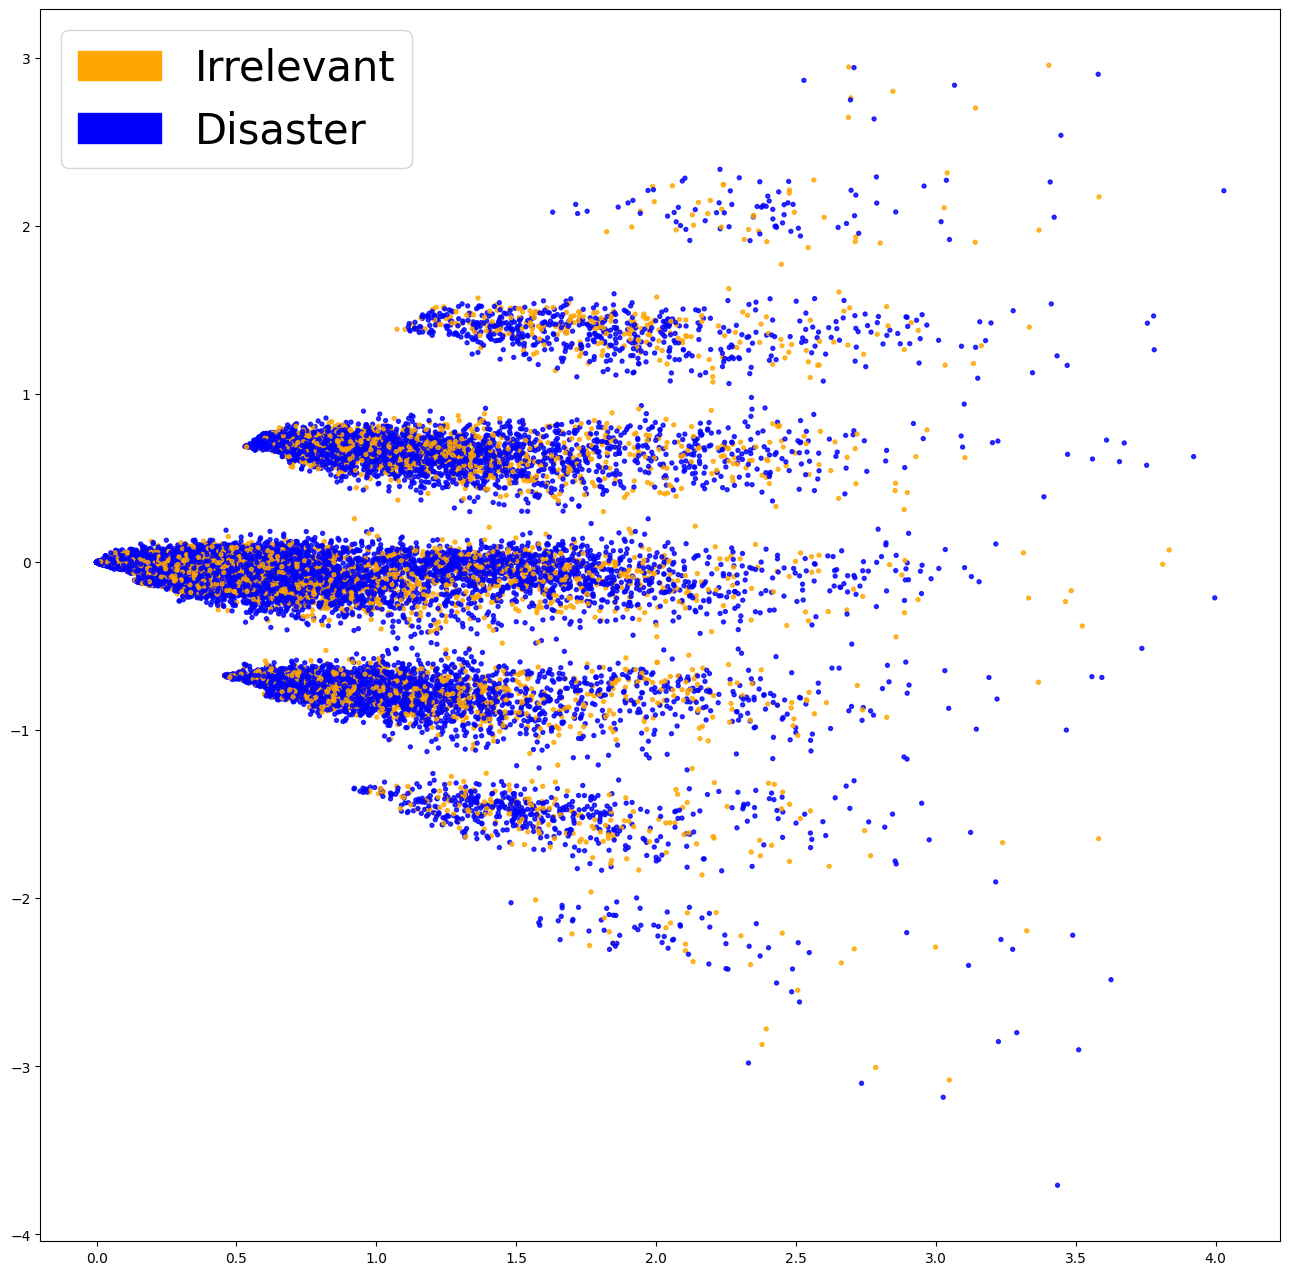

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

# Шаг 4. Классификация

### Fitting a classifier

Когда вы в первый раз принимаетесь за задачу, общепринятой практикой является начать с самого простого способа или инструмента, который может решить эту задачу. Когда дело касается классификации данных, наиболее распространенным способом является логистическая регрессия из-за своей универсальности и легкости толкования. Ее очень просто обучить, и ее результаты можно интерпретировать, поскольку вы можете с легкостью извлечь все самые важные коэффициенты из модели.

После обучения мы получаем точность в 75.4%. Не так уж и плохо! Угадывание самого частого класса («нерелеватно») дало бы нам лишь 57%.

Однако, даже если результата с 75% точностью было бы достаточно для наших нужд, мы никогда не должны использовать модель в продакшне без попытки понять ее.


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Метрики!


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report

def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

accuracy, precision, recall, f1, r2 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.647, precision = 0.647, recall = 0.647, f1 = 0.647, r2 = -0.261


# Шаг 5.

### Инспектирование
Матрица ошибок

Первый шаг — это понять, какие типы ошибок совершает наша модель, и с какими видами ошибок нам в дальнейшем хотелось бы встречаться реже всего. В случае нашего примера, ложно-положительные результаты классифицируют нерелевантный твит в качестве катастрофы, ложно-отрицательные — классифицируют катастрофу как нерелевантный твит. Если нашим приоритетом является реакция на каждое потенциальное событие, то мы захотим снизить наши ложно-отрицательные срабатывания. Однако, если мы ограничены в ресурсах, то мы можем приоритезировать более низкую частоту ложно-отрицательных срабатываний для уменьшения вероятности ложной тревоги. Хорошим способом визуализации данной информации является использование матрицы ошибок, которая сравнивает предсказания, сделанные нашей моделью, с реальными метками. В идеале, данная матрица будет представлять собой диагональную линию, идущую из левого верхнего до нижнего правого угла (это будет означать, что наши предсказания идеально совпали с правдой).

In [ ]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

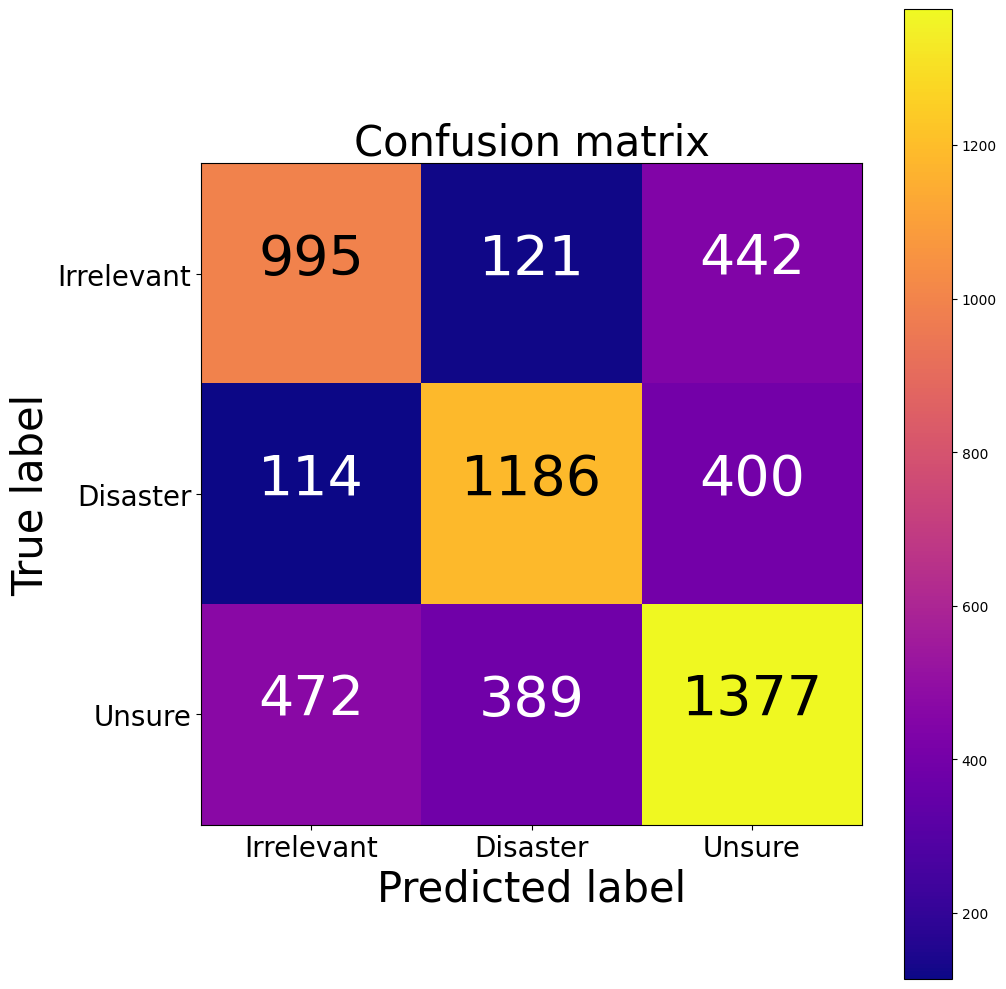

[[ 995  121  442]
 [ 114 1186  400]
 [ 472  389 1377]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix', cmap="plasma")
plt.show()
print(cm)

Наш классификатор создает больше ложно-отрицательных, чем ложно-положительных результатов (пропорционально). Другими словами, самая частая ошибка нашей модели состоит в неточной классификации катастроф как нерелевантных. Если ложно-положительные отражают высокую стоимость для правоохранительных органов, то это может стать хорошим вариантом для нашего классификатора.

### Инспектируем дальше

Чтобы произвести валидацию нашей модели и интерпретировать ее предсказания, важно посмотреть на то, какие слова она использует для принятия решений. Если наши данные смещены, наш классификатор произведет точные предсказания на выборочных данных, но модель не сможет достаточно хорошо обобщить их в реальном мире. На диаграмме ниже показаны наиболее значимые слова для классов катастроф и нерелевантных твитов. Составление диаграмм, отражающих значимость слов, не составляет трудностей в случае использования «мешка слов» и логистической регрессии, поскольку мы просто извлекаем и ранжируем коэффициенты, которые модель использует для своих предсказаний.

Посмотрим, на каких признаках наш классификатор делает предсказание.

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

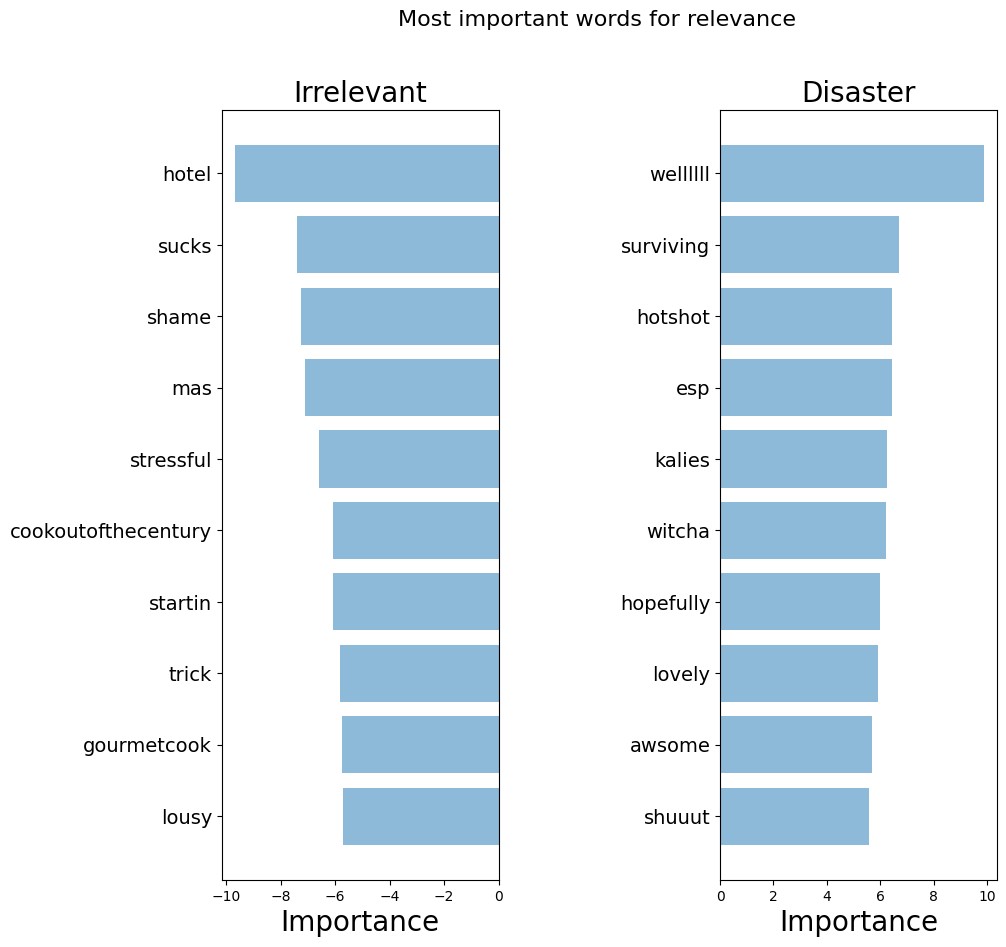

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Наш классификатор верно нашел несколько паттернов (hiroshima — «Хиросима», massacre — «резня»), но ясно видно, что он переобучился на некоторых бессмысленных терминах («heyoo», «x1392»). Итак, сейчас наш «мешок слов» имеет дело с огромным словарем из различных слов и все эти слова для него равнозначны. Однако, некоторые из этих слов встречаются очень часто, и лишь добавляют шума нашим предсказаниям. Поэтому далее мы постараемся найти способ представить предложения таким образом, чтобы они могли учитывать частоту слов, и посмотрим, сможем ли мы получить больше полезной информации из наших данных.

# Шаг 6. Учтите структуру словаря

### TFIDF Bag of Words

Чтобы помочь нашей модели сфокусироваться на значимых словах, мы можем использовать скоринг TF-IDF (Term Frequency, Inverse Document Frequency) поверх нашей модели «мешка слов». TF-IDF взвешивает на основании того, насколько они редки в нашем датасете, понижая в приоритете слова, которые встречаются слишком часто и просто добавляют шум. Ниже приводится проекция метода главных компонент, позволяющая оценить наше новое представление.

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

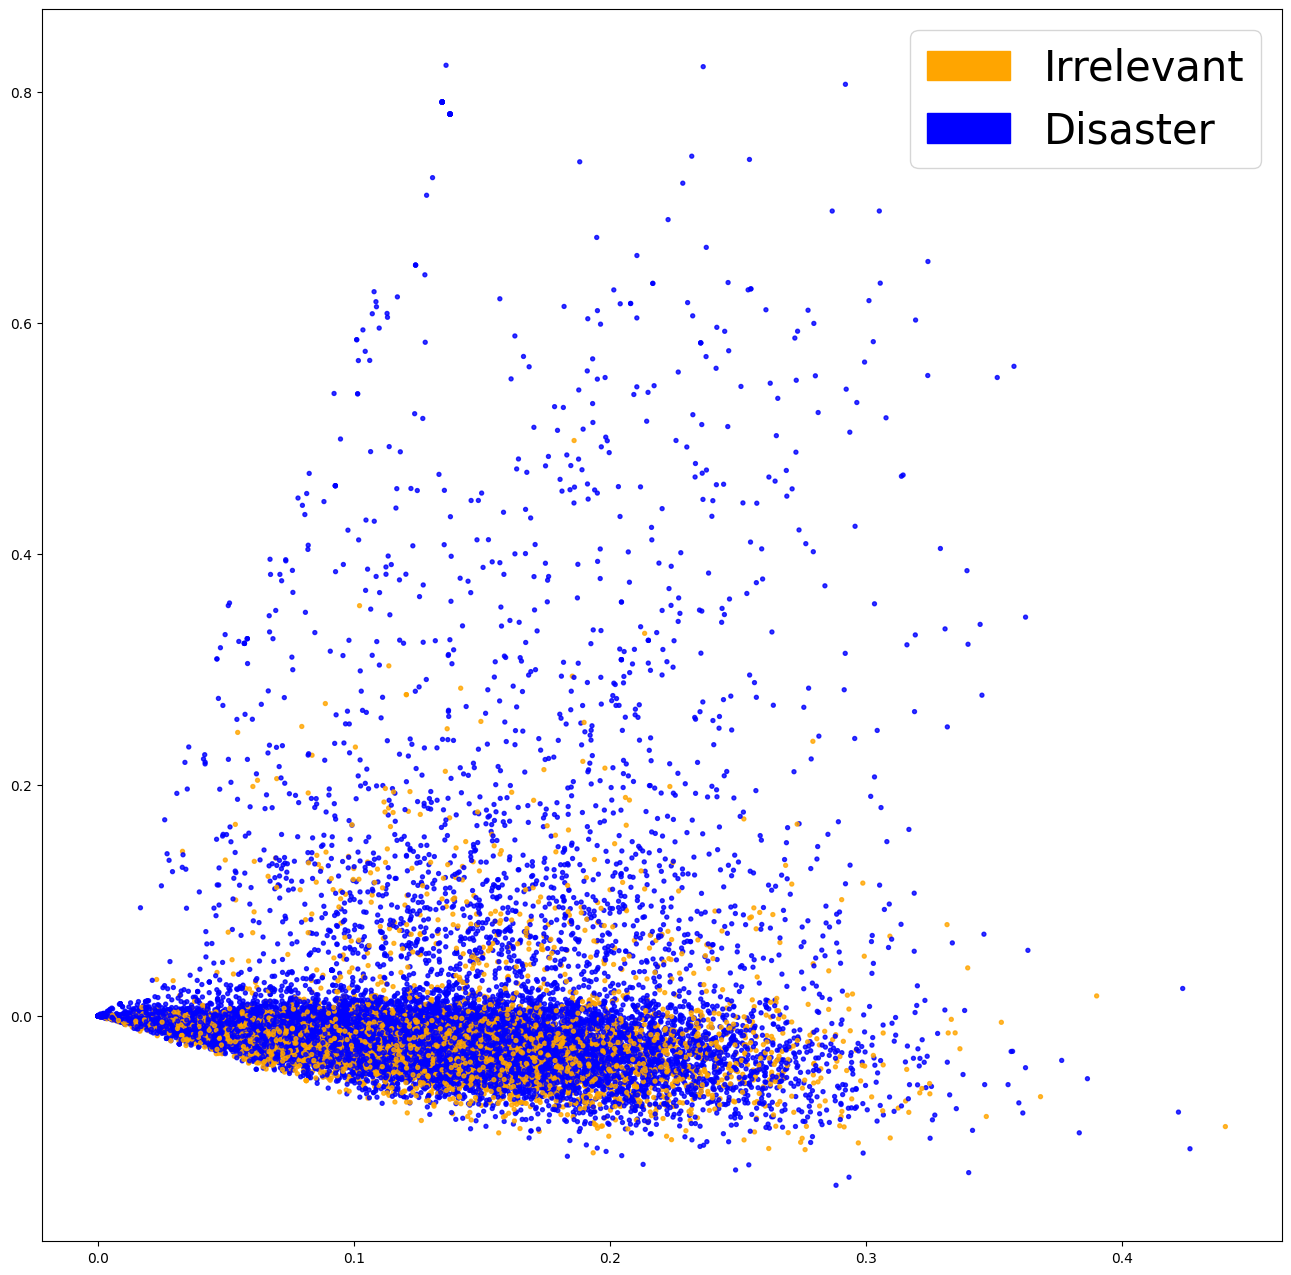

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

При некоторой фантазии, мы можем наблюдать более четкое разделение между двумя цветами. Это свидетельствует о том, что нашему классификатору должно стать проще разделить обе группы.

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.658, precision = 0.658, recall = 0.658, f1 = 0.658, r2 = -0.242


Результаты получше

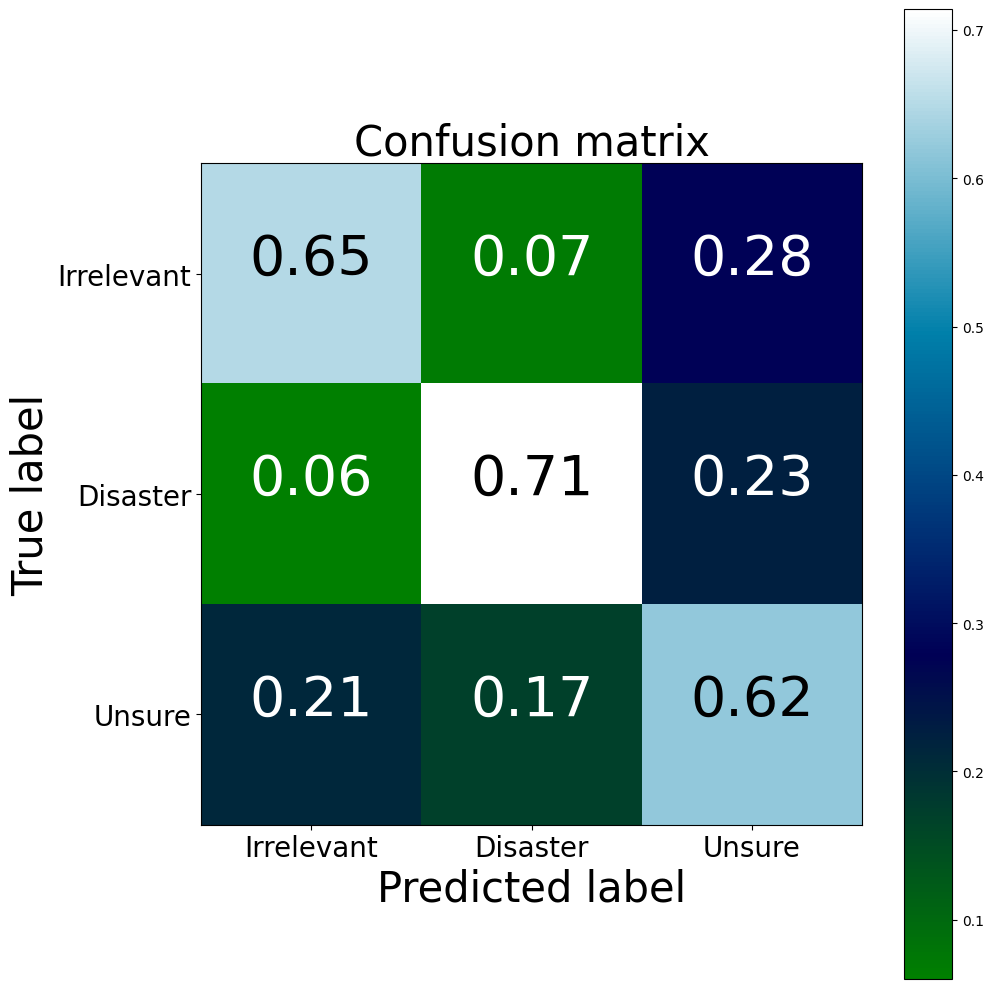

TFIDF confusion matrix
[[1012  109  437]
 [ 102 1214  384]
 [ 473  375 1390]]
BoW confusion matrix
[[ 995  121  442]
 [ 114 1186  400]
 [ 472  389 1377]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=True, title='Confusion matrix', cmap="ocean")
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Сравним две матрицы

### Посмотрим, какие признаки были важны для предсказания


In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

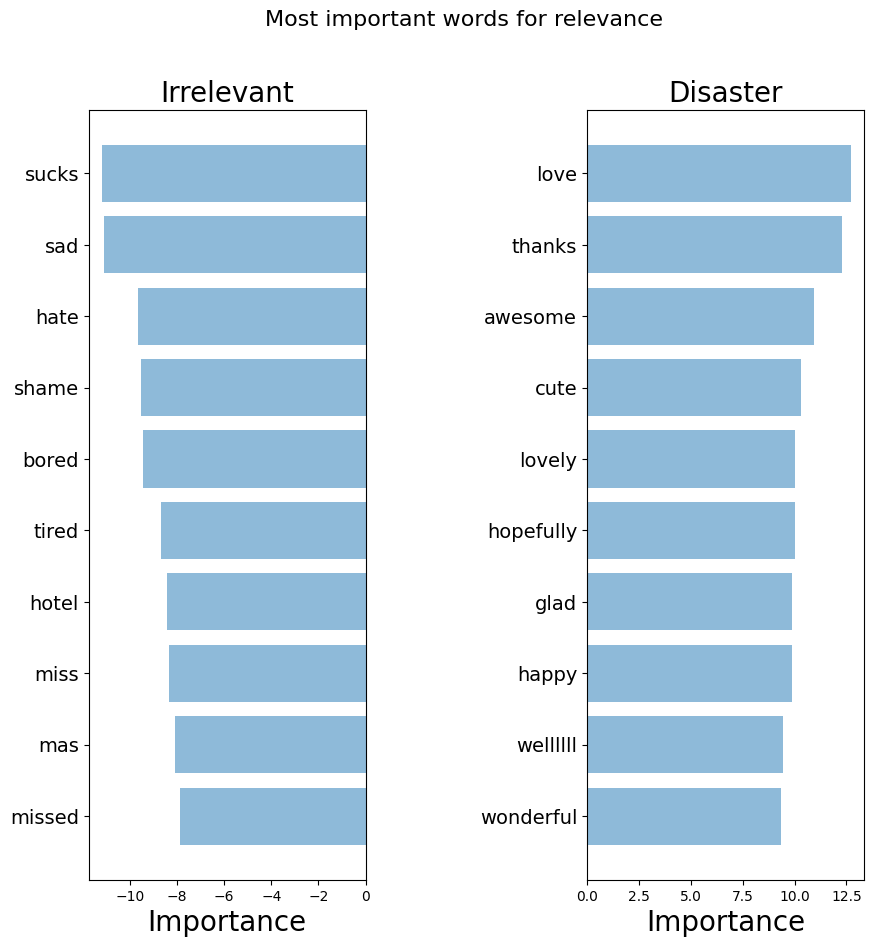

In [ ]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Выбранные моделью слова действительно выглядят гораздо более релевантными. Несмотря на то, что метрики на нашем тестовом множестве увеличились совсем незначительно, у нас теперь гораздо больше уверенности в использовании модели в реальной системе, которая будет взаимодействовать с клиентами.

# Шаг 7

### Применение семантики

Word2Vec

Наша последняя модель смогла «выхватить» слова, несущие наибольшее значение. Однако, скорее всего, когда мы выпустим ее в продакшн, она столкнется со словами, которые не встречались в обучающей выборке — и не сможет точно классифицировать эти твиты, даже если она видела весьма похожие слова во время обучения.

Чтобы решить данную проблему, нам потребуется захватить семантическое (смысловое) значение слов — это означает, что для нас важно понимать, что слова «хороший» и «позитивный» ближе друг к другу, чем слова «абрикос» и «континент». Мы воспользуемся инструментом Word2Vec, который поможет нам сопоставить значения слов.

Использование результатов предварительного обучения

Word2Vec — это техника для поиска непрерывных отображений для слов. Word2Vec обучается на прочтении огромного количества текста с последующим запоминанием того, какое слово возникает в схожих контекстах. После обучения на достаточном количестве данных, Word2Vec генерирует вектор из 300 измерений для каждого слова в словаре, в котором слова со схожим значением располагаются ближе друг к другу.

Авторы публикации на тему непрерывных векторных представлений слов выложили в открытый доступ модель, которая была предварительно обучена на очень большом объеме информации, и мы можем использовать ее в нашей модели, чтобы внести знания о семантическом значении слов.

Взять можно тут:
python -m gensim.downloader --download word2vec-google-news-300

In [ ]:
!python -m gensim.downloader --download word2vec-google-news-300

2024-12-19 07:58:36,059 : __main__ : INFO : Creating /root/gensim-data
[==================================================] 100.0% 1662.8/1662.8MB downloaded
2024-12-19 08:00:08,114 : __main__ : INFO : word2vec-google-news-300 downloaded
2024-12-19 08:00:08,114 : __main__ : INFO : Data has been installed and data path is /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

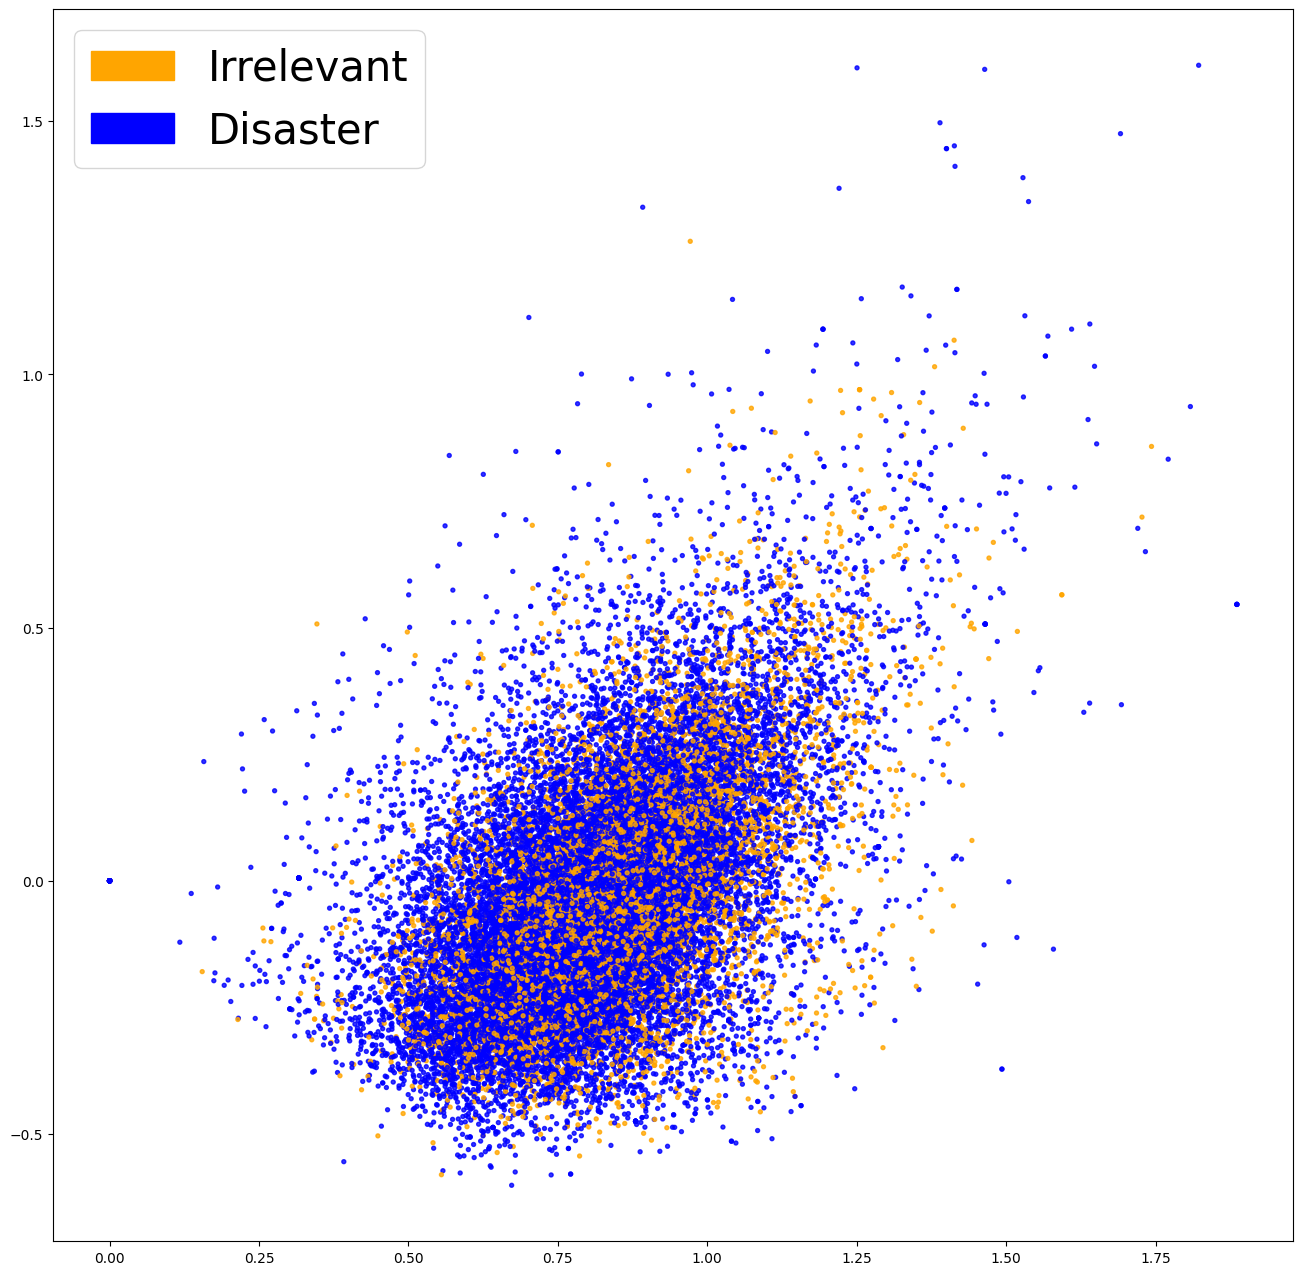

In [ ]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show()

Разделение видно

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.666, precision = 0.666, recall = 0.666, f1 = 0.666, r2 = -0.201


По-прежнему становится лучше, давайте построим матрицу путаницы

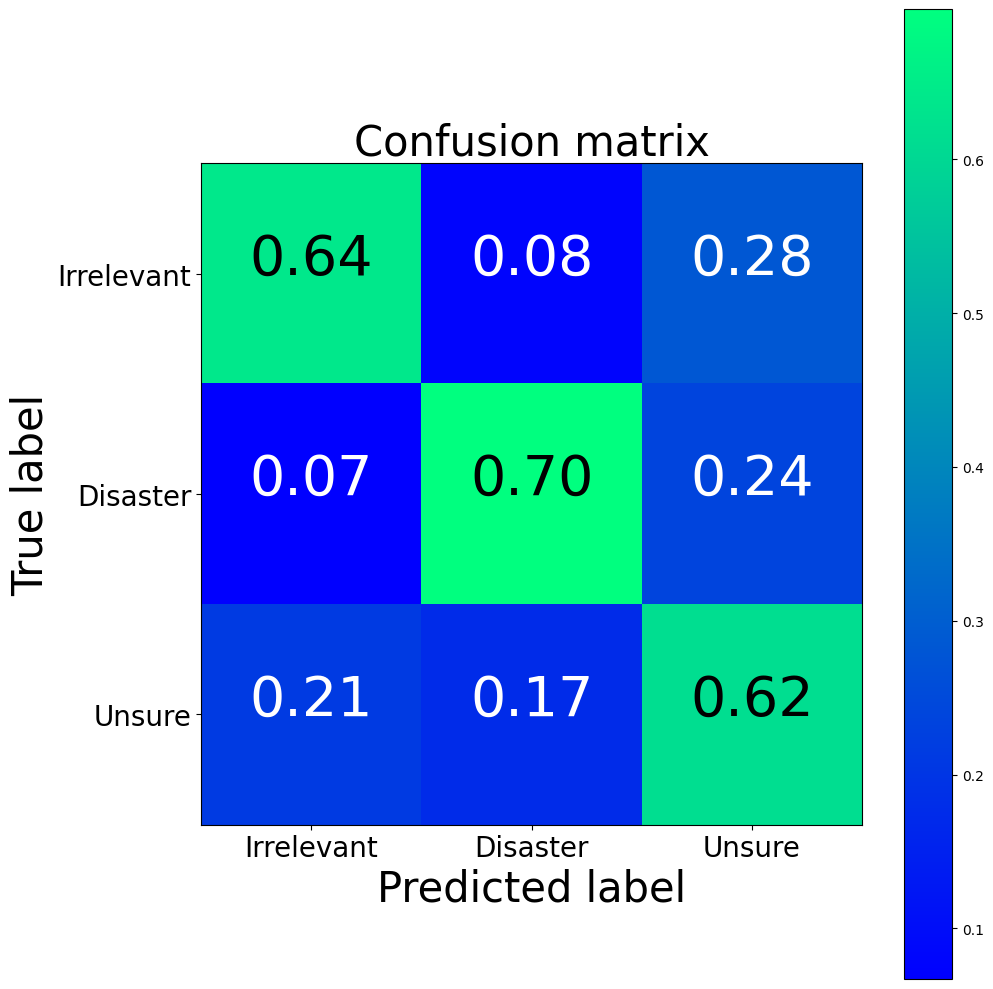

Word2Vec confusion matrix
[[1044  117  397]
 [ 116 1208  376]
 [ 476  356 1406]]
TFIDF confusion matrix
[[1012  109  437]
 [ 102 1214  384]
 [ 473  375 1390]]
BoW confusion matrix
[[ 995  121  442]
 [ 114 1186  400]
 [ 472  389 1377]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Further inspection
Поскольку наши векторные представления более не представлены в виде вектора с одним измерением на слово, как было в предыдущих моделях, теперь тяжелее понять, какие слова наиболее релевантны для нашей классификации. Несмотря на то, что мы по-прежнему обладаем доступом к коэффициентам нашей логистической регрессии, они относятся к 300 измерениям наших вложений, а не к индексам слов.

Для столь небольшого прироста точности, полная потеря возможности объяснить работу модели — это слишком жесткий компромисс. К счастью, при работе с более сложными моделями мы можем использовать интерпретаторы наподобие LIME, которые применяются для того, чтобы получить некоторое представление о том, как работает классификатор.

#### LIME

LIME доступен на Github в виде открытого пакета. Данный интерпретатор, работающий по принципу черного ящика, позволяет пользователям объяснять решения любого классификатора на одном конкретном примере при помощи изменения ввода (в нашем случае — удаления слова из предложения) и наблюдения за тем, как изменяется предсказание.

Давайте взглянем на пару объяснений для предложений из нашего датасета.

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ea65b867534a24b54485ce9a3d0efe66204af1586bfdc945f48f71b7190e96a0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [ ]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: unknown


In [ ]:
visualize_one_exp(X_test_data, y_test_data, 60)

Index: 60
True class: unknown


Впрочем, у нас нет достаточного количества времени, чтобы исследовать тысячи примеров из нашего датасета. Вместо этого, давайте запустим LIME на репрезентативной выборке тестовых данных, и посмотрим, какие слова встречаются регулярно и вносят наибольший вклад в конечный результат. Используя данный подход, мы можем получить оценки значимости слов аналогично тому, как мы делали это для предыдущих моделей, и валидировать предсказания нашей модели.

In [ ]:
import random
from collections import defaultdict

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

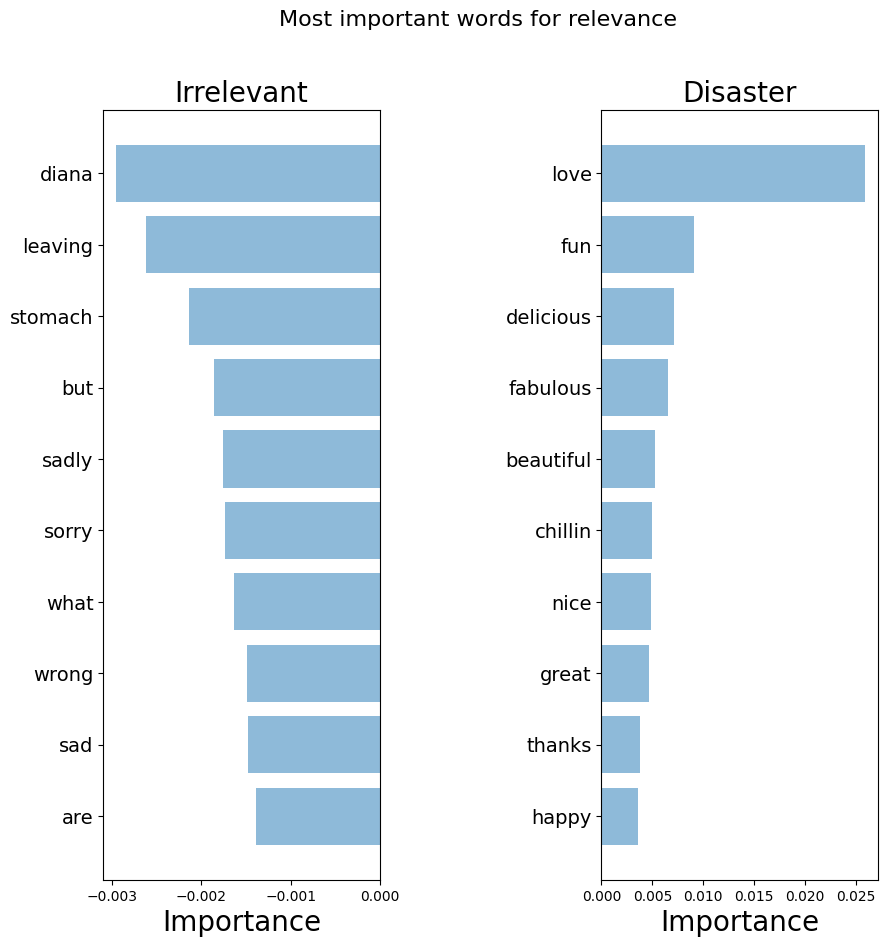

In [ ]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Похоже на то, что модель выбирает высоко релевантные слова и соответственно принимает понятные решения. По сравнению со всеми предыдущими моделями, она выбирает наиболее релевантные слова, поэтому лучше будет отправить в продакшн именно ее.

# Шаг 8. Использование синтаксиса при применении end-to-end подходов

Мы рассмотрели быстрые и эффективные подходы для генерации компактных векторных представлений предложений. Однако, опуская порядок слов, мы отбрасываем всю синтаксическую информацию из наших предложений. Если эти методы не дают достаточных результатов, вы можете использовать более сложную модель, которая принимает целые выражения в качестве ввода и предсказывает метки, без необходимости построения промежуточного представления. Распространенный для этого способ состоит в рассмотрении предложения как последовательности индивидуальных векторов слов с использованием или Word2Vec, или более свежих подходов вроде GloVe или CoVe. Именно этим мы и займемся далее.

### CNN для NLP

Сверточные нейронные сети для классификации предложений (CNNs for Sentence Classification) обучаются очень быстро и могут сослужить отличную службу в качестве входного уровня в архитектуре глубокого обучения. Несмотря на то, что сверточные нейронные сети (CNN) в основном известны своей высокой производительностью на данных-изображениях, они показывают превосходные результаты при работе с текстовыми данными, и обычно гораздо быстрее обучаются, чем большинство сложных подходов NLP (например, LSTM-сети и архитектуры Encoder/Decoder ). Эта модель сохраняет порядок слов и обучается ценной информации о том, какие последовательности слов служат предсказанием наших целевых классов. В отличии от предыдущих моделей, она в курсе существования разницы между фразами «Лёша ест растения» и «Растения едят Лёшу».

In [ ]:
clean_questions.head()

Unnamed: 0      textID                                               text  \
0           0  cb774db0d1                i`d have responded, if i were going   
1           1  549e992a42      sooo sad i will miss you here in san diego!!!   
2           2  088c60f138                          my boss is bullying me...   
3           3  9642c003ef                     what interview! leave me alone   
4           4  358bd9e861   sons of ****, why couldn`t they put them on t...   

                         selected_text  sentiment  \
0  i`d have responded, if i were going          2   
1                             sooo sad          0   
2                          bullying me          0   
3                       leave me alone          0   
4                        sons of ****,          0   

                                              tokens  
0        [i, d, have, responded, if, i, were, going]  
1  [sooo, sad, i, will, miss, you, here, in, san,...  
2                       [my, boss, is, bullying, me]  
3                [what, interview, leave, me, alone]  
4  [sons, of, why, couldn, t, they, put, them, on...

In [ ]:
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["sentiment"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 26597 unique tokens.
(26598, 300)


Собираем простейшую CNN

In [ ]:
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Теперь давайте потренируем нашу Нейронную сеть



In [ ]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions["sentiment"].unique())), False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 47s 258ms/step - acc: 0.4362 - loss: 1.0617 - val_acc: 0.6618 - val_loss: 0.7642
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 80s 248ms/step - acc: 0.6744 - loss: 0.7403 - val_acc: 0.6778 - val_loss: 0.7227
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 283ms/step - acc: 0.7235 - loss: 0.6512 - val_acc: 0.7065 - val_loss: 0.6854


In [ ]:
y_pred = model.predict(x_val)

172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


In [ ]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [ ]:
y_val_cnn

array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.707, precision = 0.712, recall = 0.707, f1 = 0.705, r2 = -0.031


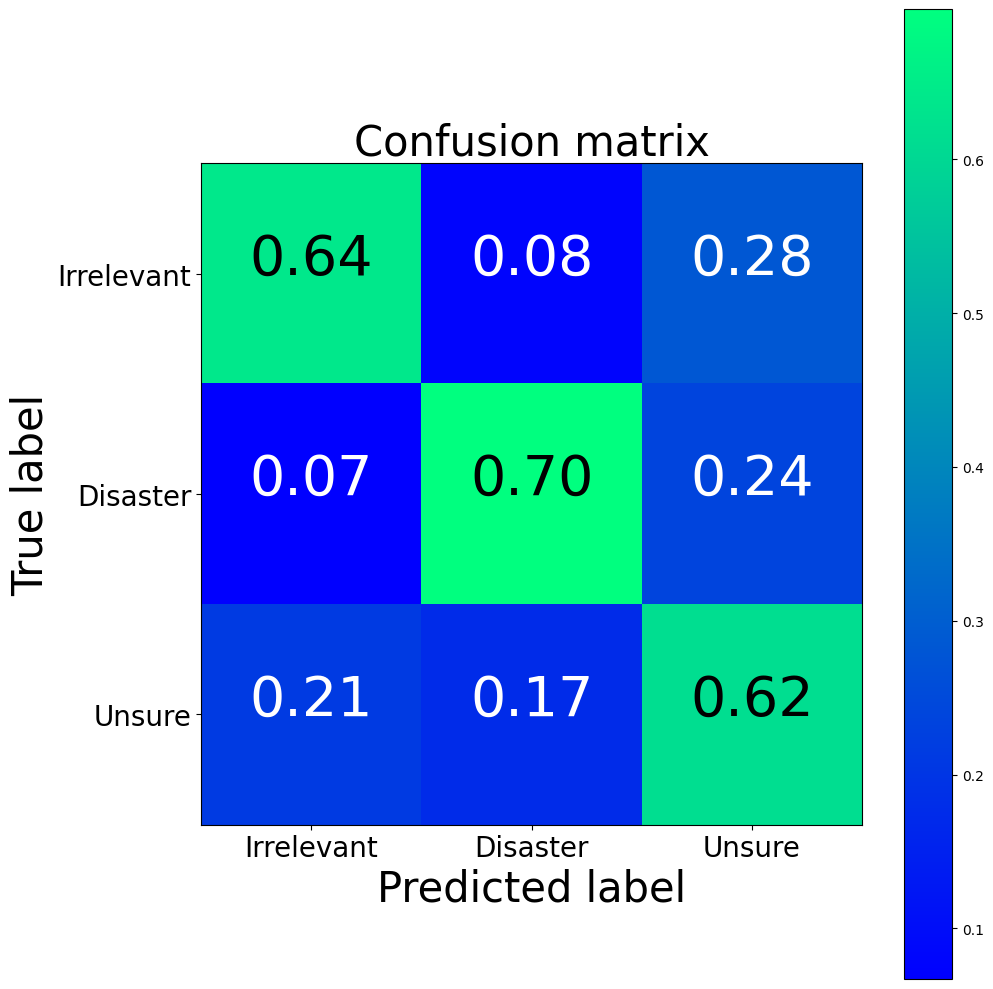

CNN confusion matrix
[[ 952  106  510]
 [  44 1329  319]
 [ 232  402 1602]]
Word2Vec confusion matrix
[[1044  117  397]
 [ 116 1208  376]
 [ 476  356 1406]]
TFIDF confusion matrix
[[1012  109  437]
 [ 102 1214  384]
 [ 473  375 1390]]
BoW confusion matrix
[[ 995  121  442]
 [ 114 1186  400]
 [ 472  389 1377]]


In [ ]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)